<a href="https://colab.research.google.com/github/gunjan2014/Colab-work/blob/main/LST_from_MODIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load/import library
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=8iJbLSuLOP6X0Ye7jAQRH_-irvWWqJ7h681HaSke7Aw&tc=d4NqY8IyEwBMNzIlrc8MgTP4T04I0_HrFgCryFzjGEs&cc=yGsLnvhYW-x_U1zv2oJc-aH8cu9Ef9frNup0aT1V5WE

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWil-H4FxbN9g5QBONVYdwj0yfWan32z7u3WLkYZ2QRoMFnPvFHWOm8

Successfully saved authorization token.


In [ ]:
# the name of the sensor/satellite to download data
sensor='MYD11A1' # MOD11A1 or MYD11A1

# initial date of interest (inclusive).
i_date = '2003-01-01'

# Final date of interest (exclusive).
f_date = '2020-12-31'

# define variable of interest
my_variable='LST_Night_1km' # 'LST_Day_1km' or 'LST_Night_1km'

# Define the location of your interest as point geometry
my_lon = 86
my_lat = 28.5

# spatial resolution of the product
scale = 1000

In [ ]:
my_point = ee.Geometry.Point(my_lon, my_lat)

In [ ]:
# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/'+sensor)

In [ ]:
# Get the data for the pixel intersecting our point.
lst_my_point = lst.getRegion(my_point, scale).getInfo()

In [ ]:
# Preview first 6 rows of the result.
lst_my_point[:6]

[['id',
  'longitude',
  'latitude',
  'time',
  'LST_Day_1km',
  'QC_Day',
  'Day_view_time',
  'Day_view_angle',
  'LST_Night_1km',
  'QC_Night',
  'Night_view_time',
  'Night_view_angle',
  'Emis_31',
  'Emis_32',
  'Clear_day_cov',
  'Clear_night_cov'],
 ['2002_07_04',
  86.00021372518239,
  28.49905238869182,
  1025740800000,
  15198,
  0,
  135,
  91,
  None,
  2,
  None,
  None,
  247,
  248,
  1971,
  None],
 ['2002_07_05',
  86.00021372518239,
  28.49905238869182,
  1025827200000,
  None,
  2,
  None,
  None,
  13456,
  0,
  23,
  111,
  247,
  249,
  None,
  2000],
 ['2002_07_06',
  86.00021372518239,
  28.49905238869182,
  1025913600000,
  None,
  2,
  None,
  None,
  13490,
  0,
  14,
  15,
  247,
  248,
  None,
  3993],
 ['2002_07_07',
  86.00021372518239,
  28.49905238869182,
  1026000000000,
  15232,
  65,
  140,
  127,
  None,
  2,
  None,
  None,
  247,
  248,
  2000,
  None],
 ['2002_07_08',
  86.00021372518239,
  28.49905238869182,
  1026086400000,
  15334,
  65,
  1

In [ ]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
# apply function to convert array to dataframe
lst_df_my_point = ee_array_to_df(lst_my_point,[my_variable])
lst_df_my_point

,time,datetime,LST_Night_1km
1,1025827200000,2002-07-05,13456
2,1025913600000,2002-07-06,13490
4,1026086400000,2002-07-08,13298
7,1026345600000,2002-07-11,13412
8,1026432000000,2002-07-12,13482
...,...,...,...
7255,1654819200000,2022-06-10,13117
7256,1654905600000,2022-06-11,13460
7257,1654992000000,2022-06-12,13481
7261,1655337600000,2022-06-16,13332


In [ ]:
def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_my_point[my_variable] = lst_df_my_point[my_variable].apply(t_modis_to_celsius)

In [ ]:
# visualize head of the output
lst_df_my_point.head()

,time,datetime,LST_Night_1km
1,1025827200000,2002-07-05,-4.03
2,1025913600000,2002-07-06,-3.35
4,1026086400000,2002-07-08,-7.19
7,1026345600000,2002-07-11,-4.91
8,1026432000000,2002-07-12,-3.51


In [ ]:
# delete first column as we have already converted time to date 
del lst_df_my_point["time"]
lst_df_my_point.head()

,datetime,LST_Night_1km
1,2002-07-05,-4.03
2,2002-07-06,-3.35
4,2002-07-08,-7.19
7,2002-07-11,-4.91
8,2002-07-12,-3.51


In [ ]:
# load required packages
from plotnine import* # asterisk (*) means load all functions from plotnine
from mizani.breaks import date_breaks
from mizani.formatters import date_format

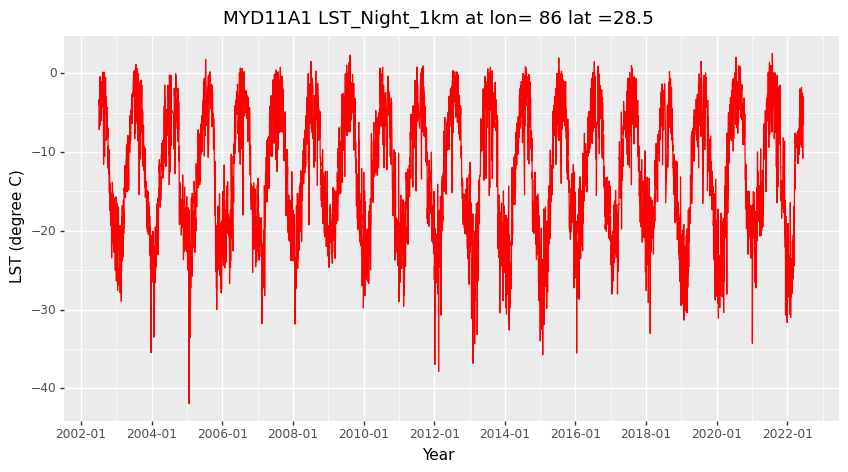

<ggplot: (8760104934749)>


In [ ]:
plot_daily_LST=(
    ggplot(lst_df_my_point)  # What data to use
    + geom_line(aes(x="datetime", y="LST_Night_1km"),colour='red')
    +ylab('LST (degree C)')+xlab('Year')
    + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y-%m'))
    +ggtitle(sensor+' '+my_variable+' at lon= '+str(my_lon)+' lat ='+str(my_lat))
    +theme(figure_size=(10, 5)) #x,y)
)

print(plot_daily_LST)

In [ ]:
# convert date colum to index
df_lst_my_point = lst_df_my_point.set_index('datetime') 

# aggregate daily to annual mean values
df_annual_LST=df_lst_my_point.resample('Y').mean()

# visualize first five rows to check output dataframe
df_annual_LST.head()

,LST_Night_1km
datetime,
2002-12-31,-12.718906
2003-12-31,-13.727614
2004-12-31,-13.756071
2005-12-31,-14.380824
2006-12-31,-12.888936


In [ ]:
# define a column name for row  <if you rerun this line you may get error, in that case run from immediate step>
df_annual_LST.index.name = 'Year'

# reset index as a column
df_annual_LST.reset_index(inplace=True)

# visualize  first five rows
df_annual_LST.head()

,Year,LST_Night_1km
0,2002-12-31,-12.718906
1,2003-12-31,-13.727614
2,2004-12-31,-13.756071
3,2005-12-31,-14.380824
4,2006-12-31,-12.888936


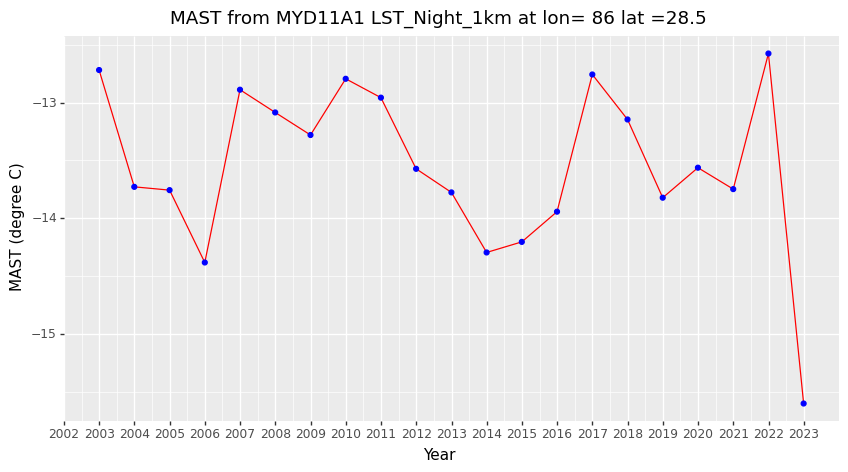

<ggplot: (8760086351997)>


In [ ]:
plot_MAAT=(
    ggplot(df_annual_LST)  # What data to use
    + geom_line(aes(x="Year", y="LST_Night_1km"),colour='red')
    + geom_point(aes(x="Year", y="LST_Night_1km"),colour='blue')
    +ylab('MAST (degree C)')+xlab('Year')
    + scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    +ggtitle('MAST from '+sensor+' '+my_variable+' at lon= '+str(my_lon)+' lat ='+str(my_lat))
    +theme(figure_size=(10, 5)) #x,y)
)

print(plot_MAAT)

In [ ]:
# load necessary files
from google.colab import files

# define output filename
my_filename=sensor+'_'+my_variable+'_lon_'+str(my_lon)+'_lat_'+str(my_lat)+'_'+i_date+'_'+f_date+'.csv'
print('my file name is: ',my_filename)

# Convert dataframe to csv
lst_df_my_point.to_csv(my_filename, encoding = 'utf-8-sig') 

# download csv
files.download(my_filename)

my file name is:  MYD11A1_LST_Night_1km_lon_86_lat_28.5_2003-01-01_2020-12-31.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>